In [42]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc
import pandas as pd


import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\density_vs_division")
save_path.mkdir(exist_ok=True)

include = [1, 3, 4, 6, 7, 8]
earliest_frames = [25, 48, 43, 63, 80, 30]

dnt.set_plot_style()
spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]

print(df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  35  60 110 160 280] 25 246


reading spots dfs: 2it [00:01,  1.92it/s]

[  0  50  80 140 200 280] 0 283


reading spots dfs: 4it [00:02,  1.64it/s]

[  0  55  90 140 200 350] 0 332


reading spots dfs: 5it [00:04,  1.03it/s]

[  0  65 100 150 225 350] 0 311


reading spots dfs: 7it [00:05,  1.19it/s]

[  0  85 125 170 225 350] 0 325


reading spots dfs: 8it [00:07,  1.08s/it]

[  0  42  65 130 200 350] 0 320


reading spots dfs: 14it [00:09,  1.47it/s]

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'status', 'source', 'is_parent', 'is_child',
       'pseudotime', 'distance', 'cycle_pseudotime', 'dx', 'dy', 'dz', 'dAP',
       'dtheta', 'dtot', 'dAP_abs'],
      dtype='object')


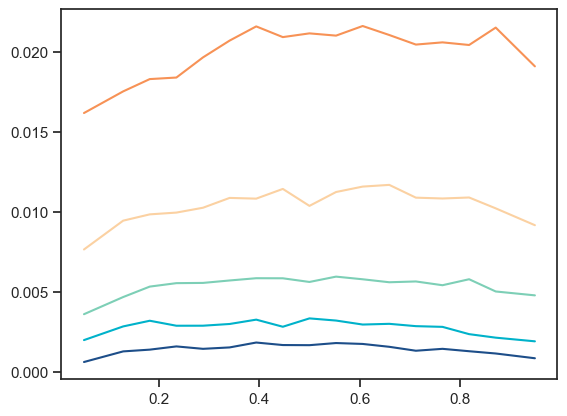

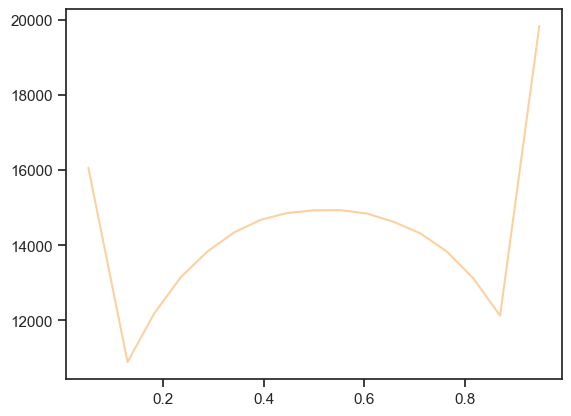

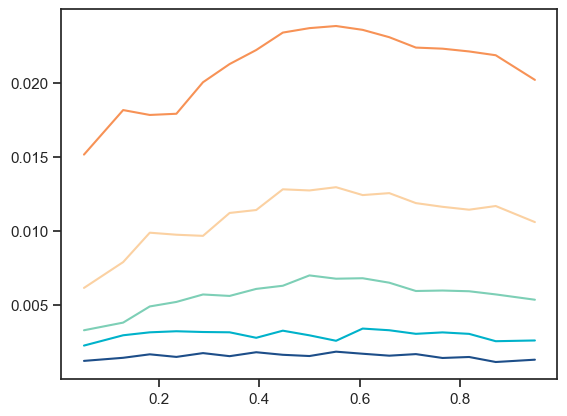

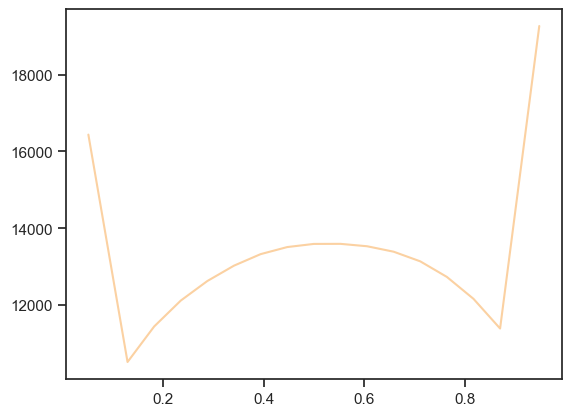

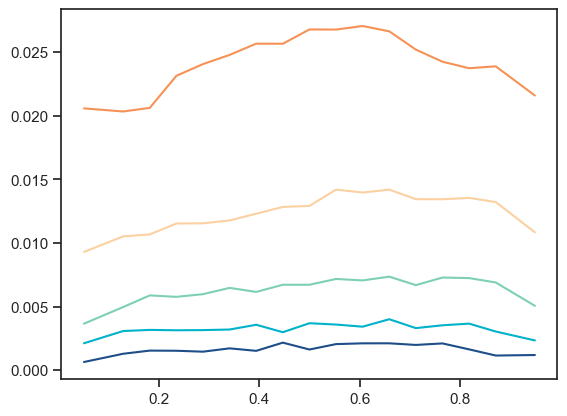

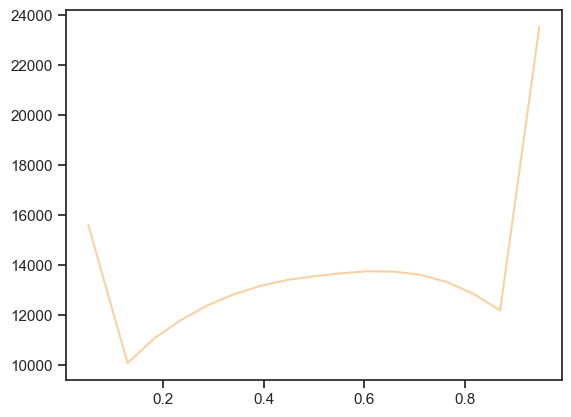

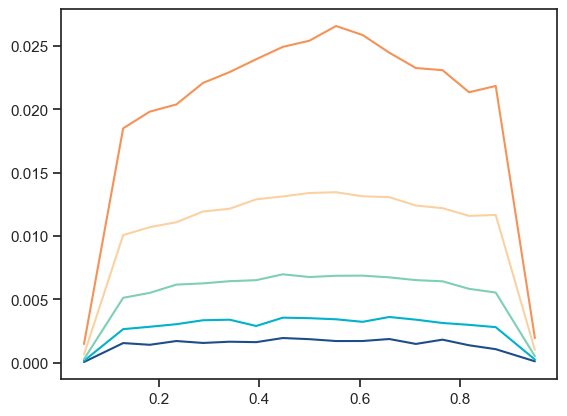

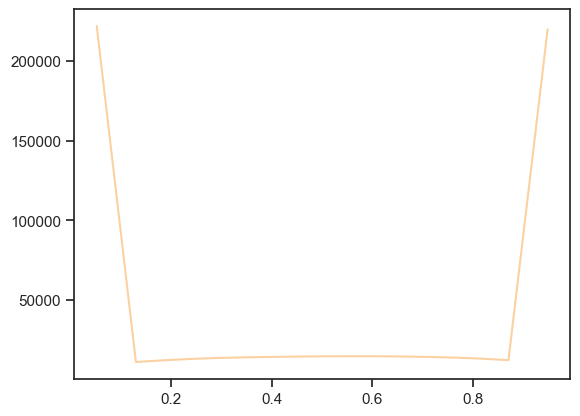

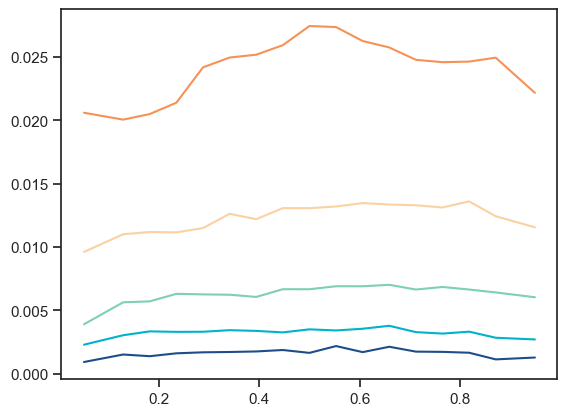

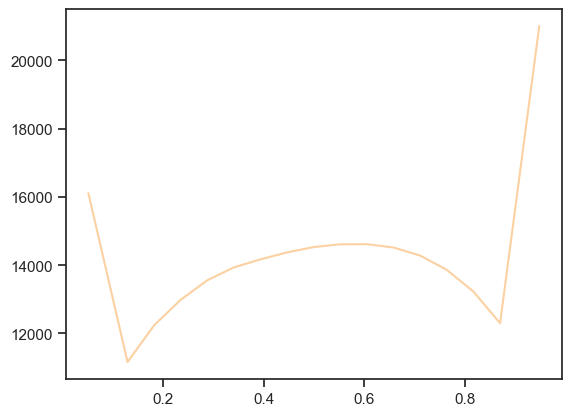

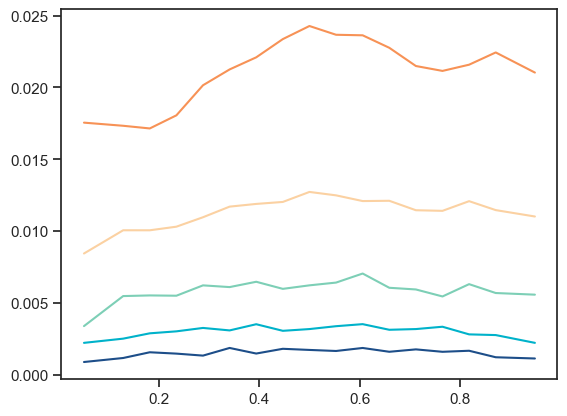

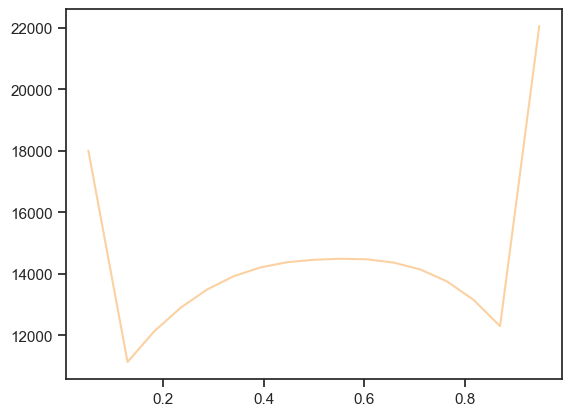

In [78]:
from sklearn.linear_model import LinearRegression
from itertools import pairwise
import pandas as pd
from collections import defaultdict

n_bins = 17

all_densities = defaultdict(list)
all_surface_areas = defaultdict(list)
ap_positions = np.linspace(0.05, 0.95, n_bins+1, endpoint=True)[1:-1]
ap_avg_values = [(a + b)/2 for a, b in pairwise([0.0, *ap_positions, 1.0])]
division_timings = defaultdict(list)
time_in_cycles = defaultdict(list)

# viewer = napari.Viewer(ndisplay=3)
# pal = sns.color_palette("Spectral", as_cmap=True)

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    # get nc_14 surface areas
    cycle = cycles[-1]
    frame = min_mvmt_frames[-1]

    c14_frame_df = df[df["frame"] == frame].copy()
    points = c14_frame_df[["z", "y", "x"]].values
    APs = c14_frame_df["AP"].values

    model = LinearRegression()
    model.fit(APs.reshape(-1, 1), points[:, 1])
    ap_y_interp = model.predict(ap_positions.reshape(-1, 1))

    mesh = dnt.mesh_from_points(points)
    surface_areas = np.abs(dnt.calculate_surface_area_along_axis(
        mesh, axis=1, dividers=ap_y_interp
    ))

    for cycle, frame in zip(cycles, min_mvmt_frames):
        cycle_df = df[df["frame"] == frame].copy()

        cycle_df["AP_bin"] = pd.cut(
            cycle_df["AP"], bins=[0, *ap_positions, 1], labels=ap_avg_values
        )

        counts = cycle_df.groupby("AP_bin", observed=True).size().values
        densities = counts / surface_areas
        densities_normed = densities / (len(cycle_df) / surface_areas.sum())

        all_densities[i].append(densities_normed)
        all_surface_areas[i].append(surface_areas)

        plt.plot(
            ap_avg_values, densities, label=f"Cycle {cycle}", color=dnt.palettes.nc[cycle]
        )

    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    df["AP_bins"] = pd.cut(
        df["AP"], bins=[0.0, *ap_positions, 1.0], labels=ap_avg_values
    )

    for cycle in cycles[1:-1]:

        cycle_df = df[df["cycle"] == cycle].copy()
        cycle_df = cycle_df[cycle_df["distance"] < 3]
        t = cycle_df.groupby("tracklet_id")[["AP",]].mean()
        t["division_times"] = cycle_df.groupby("tracklet_id")["time_since_nc11"].max().values
        t["total_times"] = t["division_times"] - cycle_df.groupby("tracklet_id")["time_since_nc11"].min().values

        t["AP_bins"] = pd.cut(
            t["AP"], bins=[0.0, *ap_positions, 1.0], labels=ap_avg_values
        )
        division_timings[i].append(t.groupby("AP_bins", observed=True)["division_times"].mean().values)
        time_in_cycles[i].append(t.groupby("AP_bins", observed=True)["total_times"].mean().values)

    plt.show()

    plt.plot(ap_avg_values, surface_areas, label=f"Cycle {cycle}", color=dnt.palettes.nc[cycle])
    plt.show()





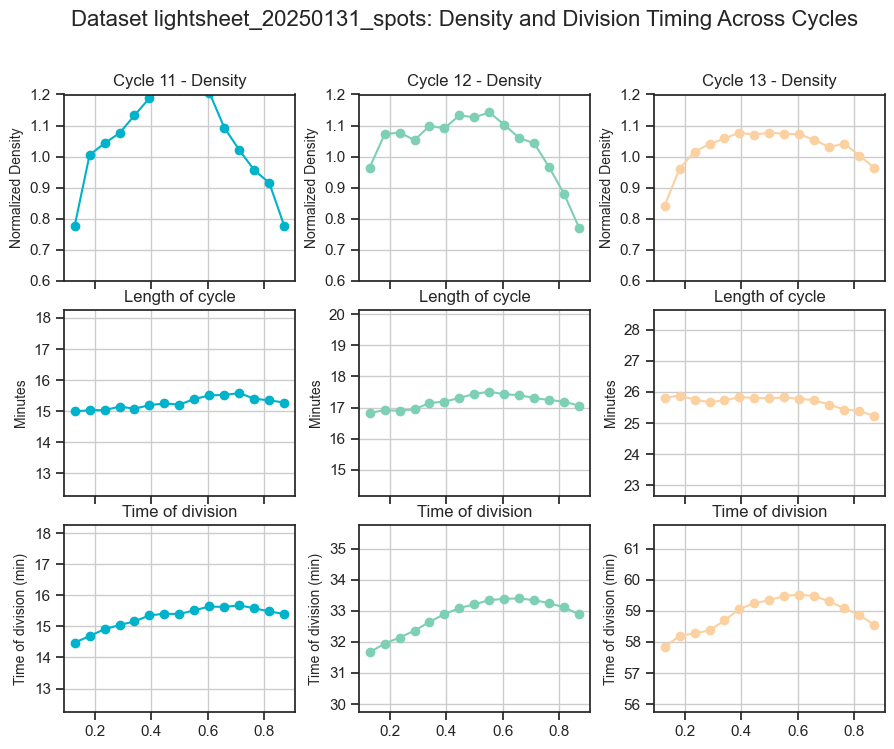

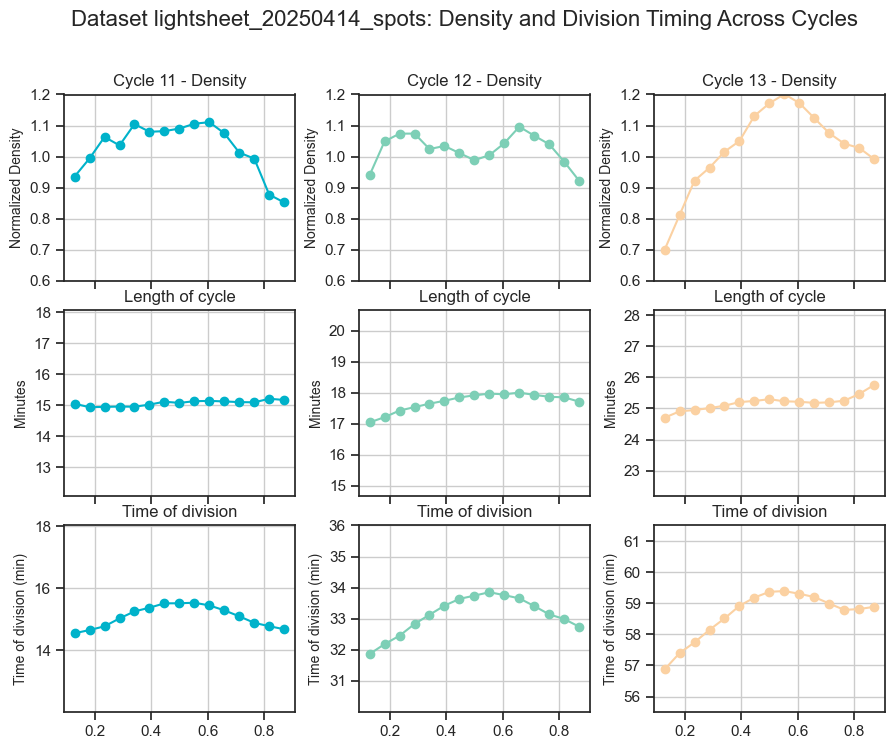

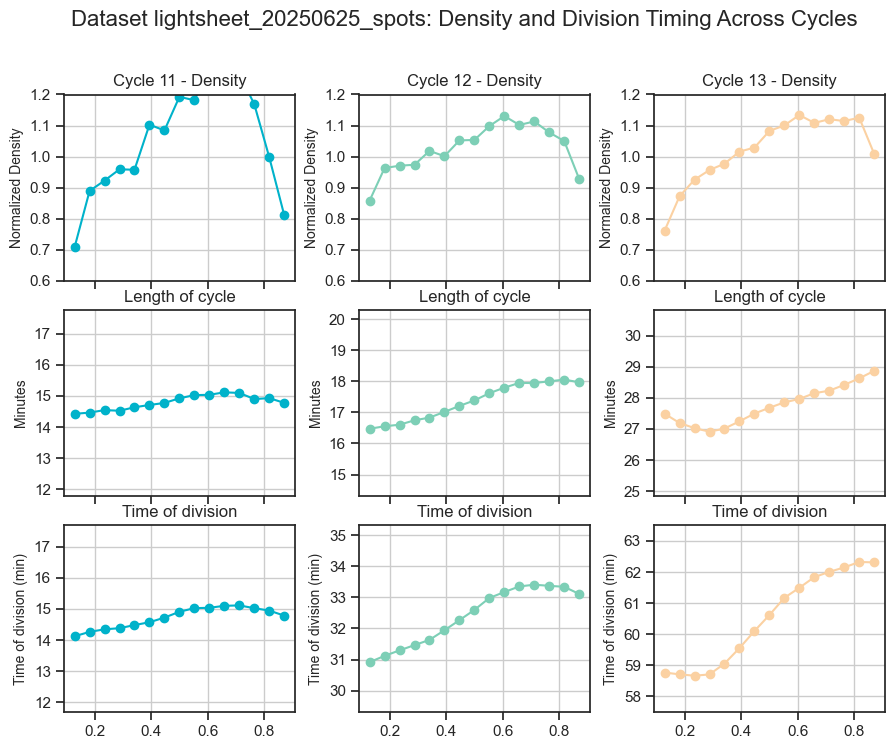

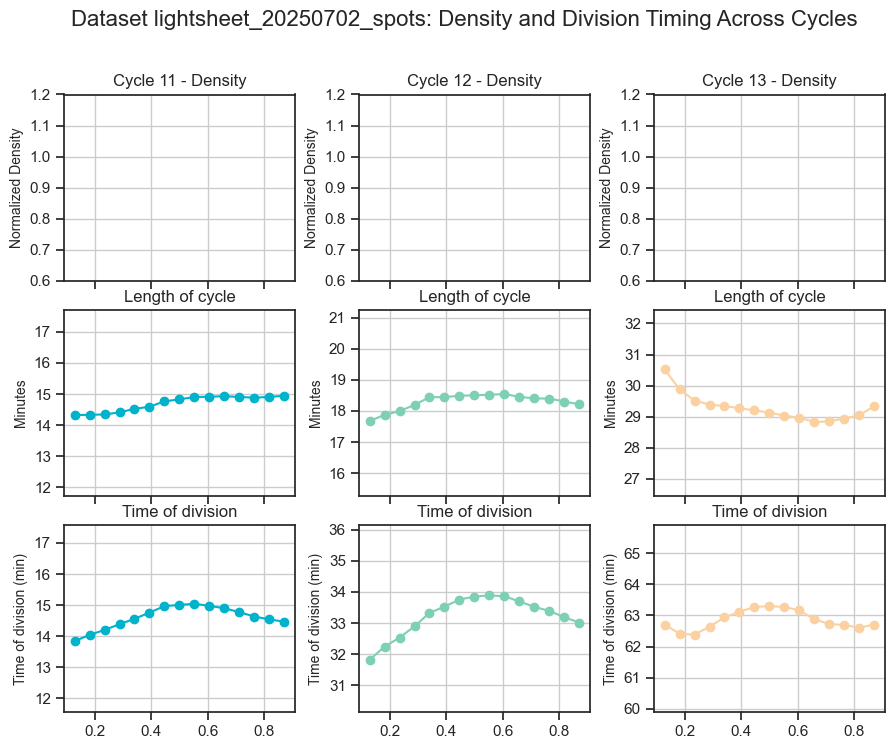

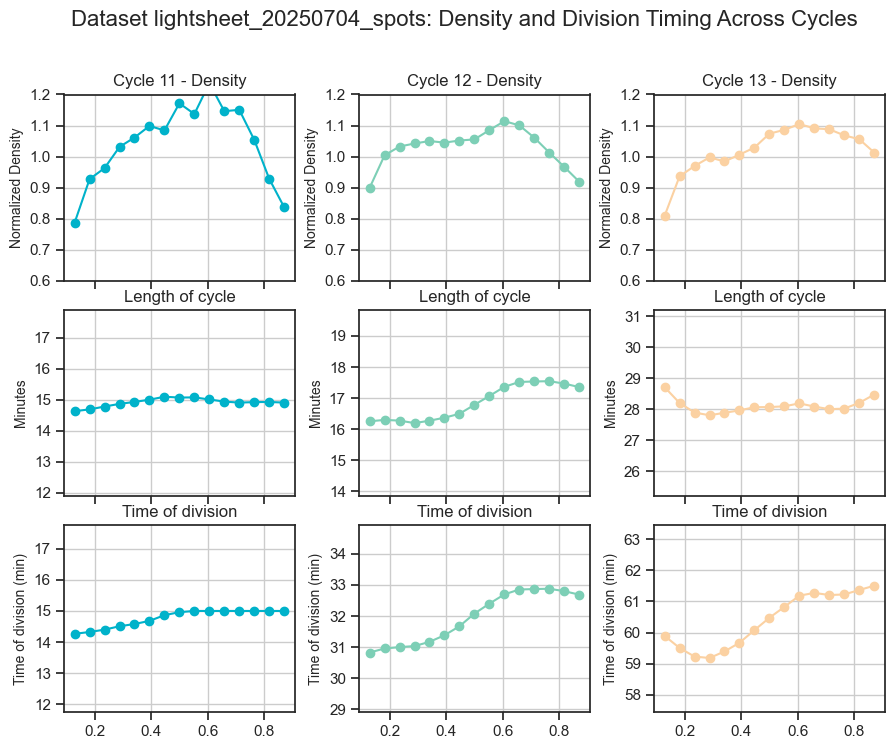

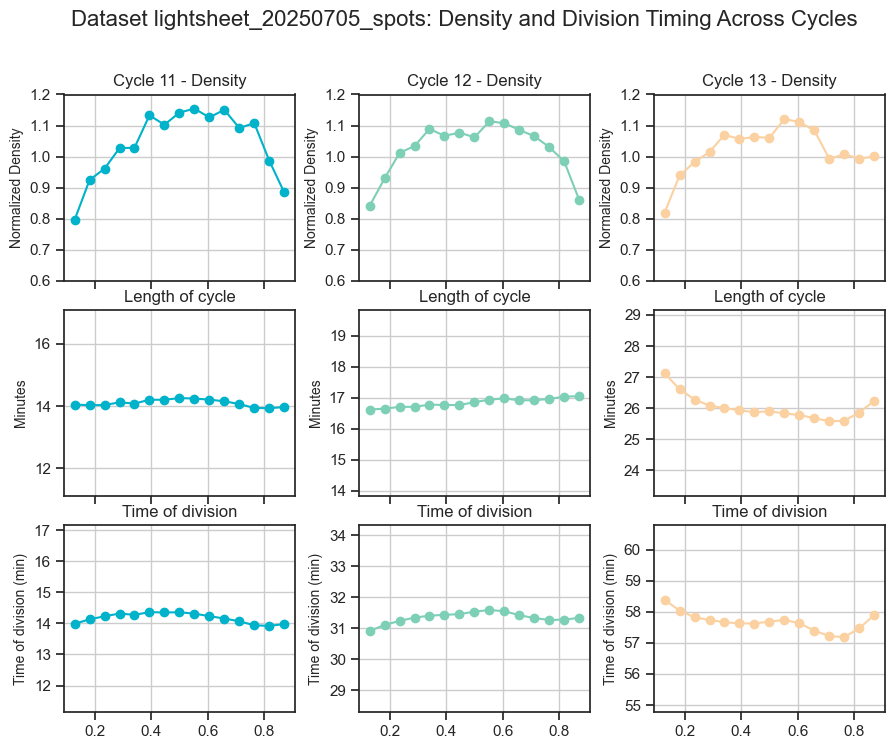

In [80]:
def rolling(x):
    return 1/3 * (x[:-2] + x[1:-1] + x[2:])

for i, df in enumerate(spots_dfs):
    fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True)
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.90])

    for j, cycle in enumerate(cycles[1:-1]):
        ax_density_start = axes[0, j]
        ax_division = axes[2, j]
        ax_time_in_cycle = axes[1, j]

        densities_start = all_densities[i][j]
        division_times = division_timings[i][j]
        cycle_times = time_in_cycles[i][j]

        ax_density_start.plot(
            ap_avg_values[1:-1], rolling(densities_start), marker='o', color=dnt.palettes.nc[cycle],
        )
        ax_density_start.set_title(f"Cycle {cycle} - Density")
        ax_density_start.set_ylabel("Normalized Density")
        ax_density_start.set_ylim(0.6, 1.2)
        ax_density_start.grid(True)

        ax_division.plot(
            ap_avg_values[1:-1], division_times[1:-1], marker='o', color=dnt.palettes.nc[cycle],
        )
        ax_division.set_title(f"Time of division")
        ax_division.set_ylabel("Time of division (min)")
        ax_division.set_ylim(division_times.mean() - 2, division_times.mean() + 2)
        ax_division.grid(True)

        ax_time_in_cycle.plot(
            ap_avg_values[1:-1], cycle_times[1:-1], marker='o', color=dnt.palettes.nc[cycle],
        )
        ax_time_in_cycle.set_title(f"Length of cycle")
        ax_time_in_cycle.set_ylabel("Minutes")
        ax_time_in_cycle.set_ylim(cycle_times.mean() - 2, cycle_times.mean() + 2)
        ax_time_in_cycle.grid(True)



    plt.suptitle(f"Dataset {stems[i]}: Density and Division Timing Across Cycles", fontsize=16)
    plt.savefig(save_path / f"density_vs_division_{stems[i]}.png", dpi=300, bbox_inches='tight')
    plt.show()